# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [2]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [3]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [4]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

In [ ]:
# Save data to CSV
for ticker, data in database.items():
    filename = f"{ticker}_data.csv"
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Functions

Model functions

In [5]:
def model_1(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [6]:
def model_2(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [35]:
def model_3(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [37]:
def model_4(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [38]:
def model_5(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [42]:
def model_6(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [43]:
def model_7(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [44]:
def model_8(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=True),
        SimpleRNN(16, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

Other functions

In [41]:
def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols):
    buy_list = []
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2 = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.0008 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None

            print('{:<2} '.format(count), 
                  '{:<8} -'.format(ticker), 
                  'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                  '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                  '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                  '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                  '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                  '|| ActStatus: {:<1}'.format(act_status), 
                  '/ MyActStatus: {:<1}'.format(my_act_status), 
                  '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                  '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                  '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                  '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                  '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = [ticker, 
                       'MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                       'TruePrice: {:<10}'.format(round(float(true_price1), 3)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        print('\nLook_back:', lb)
        index = my_confusion_matrix(true_status_list, pred_status_list)
        for i in index:
            print(symbols[i], '\n')
            
        for i in buy_list:
            print(i)
            

In [13]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [14]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1 + (pred1 * margin)
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1

    else:
        return pred1 - (pred1 * margin)

In [15]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate

Loss: 39623364.0
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 353301.812 / Pred2: 350747.781 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 352948.51   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.00038708114880137146
2  USDTBRL  - LastPrice: 5.036      / Pred1: 5.017      / Pred2: 5.034      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 33680.2265625
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 19643.787  / Pred2: 19905.035  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19643.79    / GambleProft: 1.004 / TrueProft: 1.007 || CorrectModel: 1
Loss: 23129.150390625
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2391.475   / Pred2: 2465.164   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus

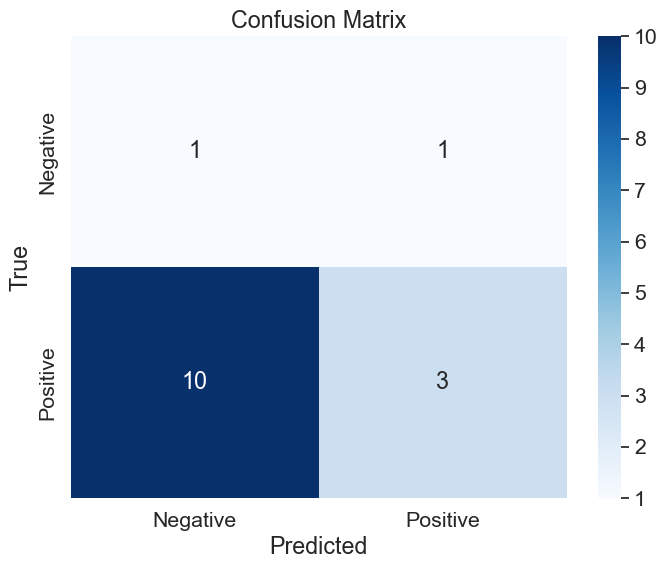

DOTBRL


In [16]:
pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 18071938.0
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 350242.656 / Pred2: 351448.281 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 349892.41   / GambleProft: 1.02  / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0012605555821210146
2  USDTBRL  - LastPrice: 5.036      / Pred1: 4.997      / Pred2: 5.023      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 594224.125
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 18860.545  / Pred2: 18944.84   / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48    / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 24628.189453125
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2414.677   / Pred2: 2451.387   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 0 

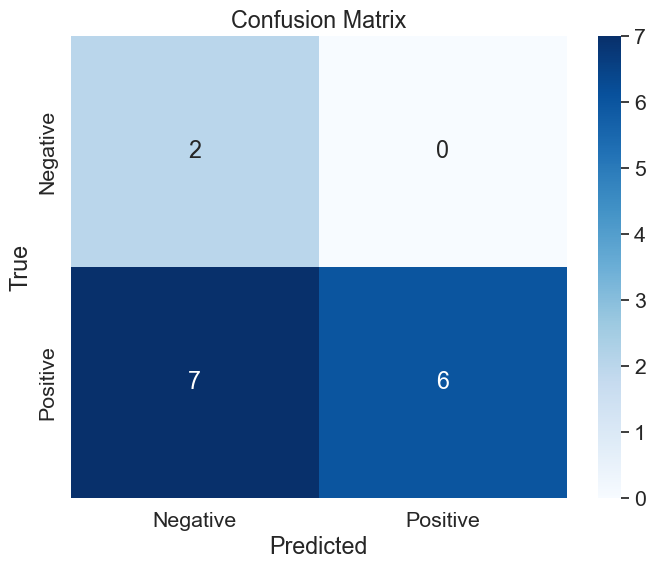

In [17]:
pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 33547036.0
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 340282.25  / Pred2: 342805.938 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0    / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 9.666620462667197e-05
2  USDTBRL  - LastPrice: 5.036      / Pred1: 5.037      / Pred2: 5.058      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 1538023.5
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 20914.168  / Pred2: 20907.846  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 20893.25    / GambleProft: 1.068 / TrueProft: 1.007 || CorrectModel: 1
Loss: 23659.958984375
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2392.947   / Pred2: 2462.057   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 0 /

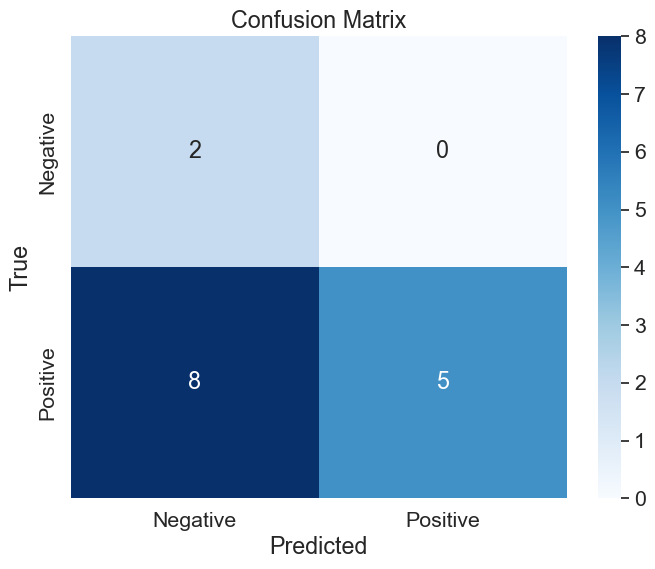

In [18]:
pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 7293.078125
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 338935.406 / Pred2: 340783.406 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0    / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.07008719444274902
2  USDTBRL  - LastPrice: 5.036      / Pred1: 4.962      / Pred2: 4.985      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 785.0751953125
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 18783.781  / Pred2: 18987.996  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48    / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 138.804931640625
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2398.951   / Pred2: 2454.439   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus

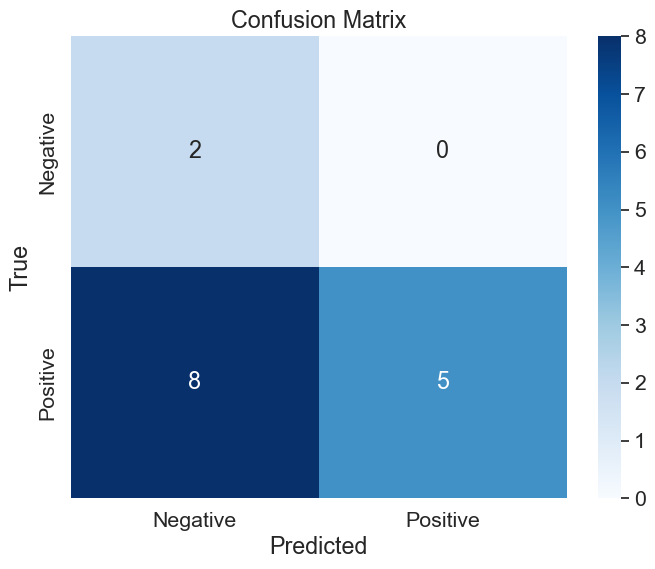

In [20]:
pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 5312.3125
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 339458.719 / Pred2: 344221.625 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0    / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.025045394897460938
2  USDTBRL  - LastPrice: 5.036      / Pred1: 5.004      / Pred2: 5.033      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 420.279296875
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 20031.51   / Pred2: 20150.98   / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 20011.48    / GambleProft: 1.023 / TrueProft: 1.007 || CorrectModel: 1
Loss: 80.4317626953125
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2467.668   / Pred2: 2511.804   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 

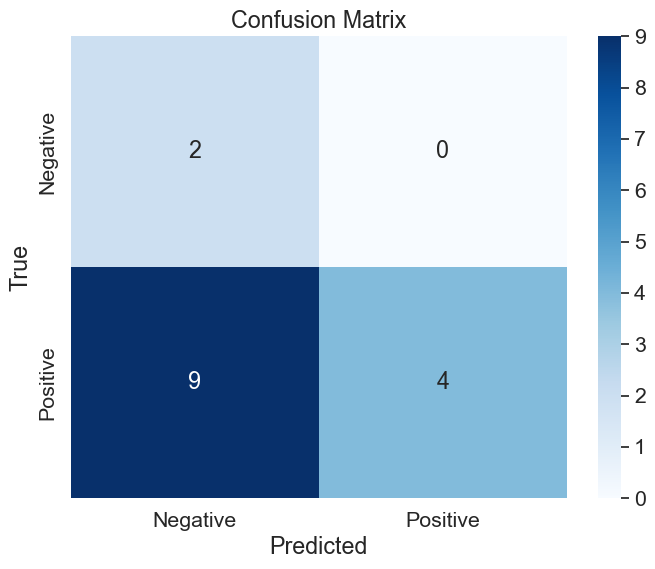

In [21]:
pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 3009.375
1  BTCBRL   - LastPrice: 343050.0   / Pred1: 348151.0   / Pred2: 352172.75  / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 348151.0    / GambleProft: 1.015 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.030524492263793945
2  USDTBRL  - LastPrice: 5.036      / Pred1: 5.001      / Pred2: 5.025      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 672.515625
3  ETHBRL   - LastPrice: 19556.48   / Pred1: 20281.291  / Pred2: 20405.67   / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 20261.01    / GambleProft: 1.036 / TrueProft: 1.007 || CorrectModel: 1
Loss: 173.3636474609375
4  BNBBRL   - LastPrice: 2449.0     / Pred1: 2367.921   / Pred2: 2416.351   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 0 /

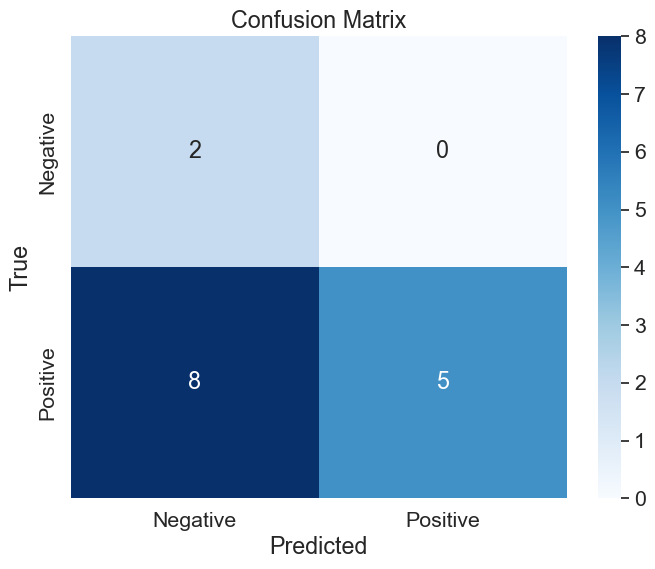

In [22]:
pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 9027619.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 343979.562 / Pred2: 345637.344 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 343635.583 / GambleProft: 1.002 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0003022286982741207
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.019      / Pred2: 5.037      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 41068.890625
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19739.65   / Pred2: 19932.596  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19719.911  / GambleProft: 1.008 / TrueProft: 1.007 || CorrectModel: 1
Loss: 12831.6015625
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2471.086   / Pred2: 2508.006   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 1 

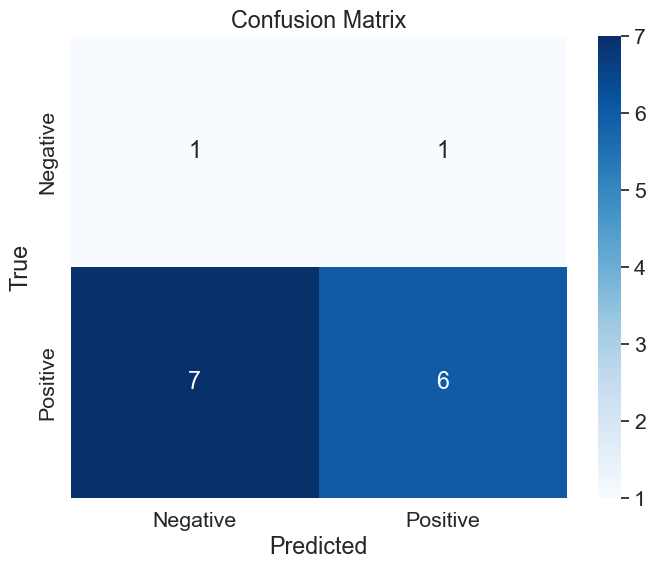

DOTBRL 

['BTCBRL   -', '/ MyGamble: 343635.583', '/ GambleProft: 1.002', '/ SoldStatus: 1', '/ TruePrice: 344444.0  ', '/ CorrectModel: 1']
['ETHBRL   -', '/ MyGamble: 19719.911 ', '/ GambleProft: 1.008', '/ SoldStatus: 1', '/ TruePrice: 19691.93  ', '/ CorrectModel: 1']
['BNBBRL   -', '/ MyGamble: 2471.086  ', '/ GambleProft: 1.009', '/ SoldStatus: 0', '/ TruePrice: 2463.0    ', '/ CorrectModel: 1']
['XRPBRL   -', '/ MyGamble: 3.152     ', '/ GambleProft: 1.01 ', '/ SoldStatus: 0', '/ TruePrice: 3.125     ', '/ CorrectModel: 1']
['ADABRL   -', '/ MyGamble: 3.697     ', '/ GambleProft: 1.016', '/ SoldStatus: 1', '/ TruePrice: 3.74      ', '/ CorrectModel: 1']
['DOTBRL   -', '/ MyGamble: 54.105    ', '/ GambleProft: 1.009', '/ SoldStatus: 0', '/ TruePrice: 52.91     ', '/ CorrectModel: 0']
Loss: 38401956.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 341251.812 / Pred2: 341699.25  / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGa

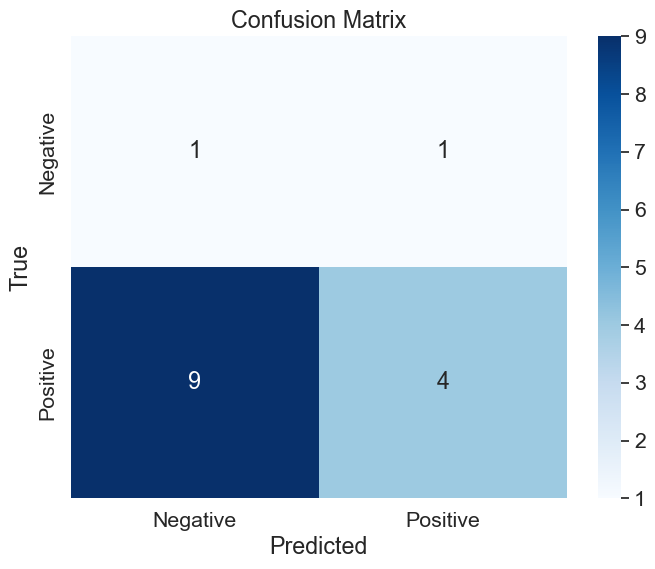

DOTBRL 

['BUSDBRL  -', '/ MyGamble: 4.98      ', '/ GambleProft: 1.001', '/ SoldStatus: 1', '/ TruePrice: 4.977     ', '/ CorrectModel: 1']
['XRPBRL   -', '/ MyGamble: 3.183     ', '/ GambleProft: 1.019', '/ SoldStatus: 0', '/ TruePrice: 3.125     ', '/ CorrectModel: 1']
['ADABRL   -', '/ MyGamble: 3.711     ', '/ GambleProft: 1.02 ', '/ SoldStatus: 1', '/ TruePrice: 3.74      ', '/ CorrectModel: 1']
['DOTBRL   -', '/ MyGamble: 54.381    ', '/ GambleProft: 1.014', '/ SoldStatus: 0', '/ TruePrice: 52.91     ', '/ CorrectModel: 0']
Loss: 3773442.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 345730.75  / Pred2: 347433.812 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 345385.019 / GambleProft: 1.007 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0002841802197508514
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.021      / Pred2: 5.034      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 /

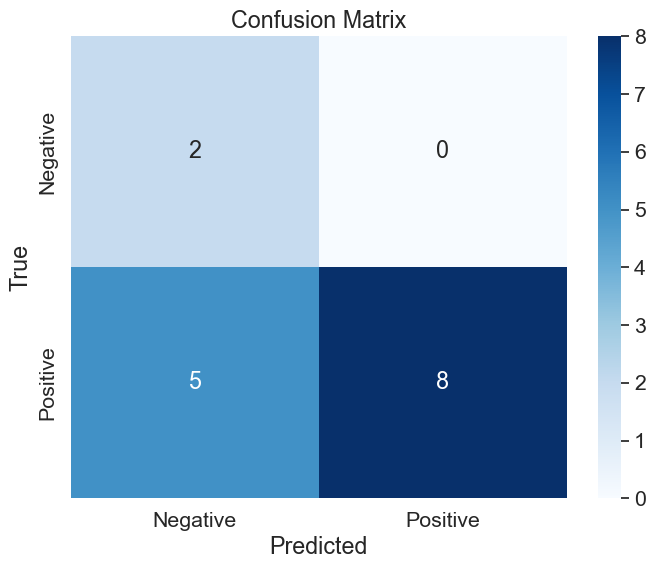

['BTCBRL   -', '/ MyGamble: 345385.019', '/ GambleProft: 1.007', '/ SoldStatus: 0', '/ TruePrice: 344444.0  ', '/ CorrectModel: 1']
['ETHBRL   -', '/ MyGamble: 19592.035 ', '/ GambleProft: 1.002', '/ SoldStatus: 1', '/ TruePrice: 19691.93  ', '/ CorrectModel: 1']
['BNBBRL   -', '/ MyGamble: 2486.615  ', '/ GambleProft: 1.015', '/ SoldStatus: 0', '/ TruePrice: 2463.0    ', '/ CorrectModel: 1']
['XRPBRL   -', '/ MyGamble: 3.215     ', '/ GambleProft: 1.03 ', '/ SoldStatus: 0', '/ TruePrice: 3.125     ', '/ CorrectModel: 1']
['LINKBRL  -', '/ MyGamble: 101.027   ', '/ GambleProft: 1.019', '/ SoldStatus: 0', '/ TruePrice: 100.73    ', '/ CorrectModel: 1']
['CHZBRL   -', '/ MyGamble: 0.774     ', '/ GambleProft: 1.003', '/ SoldStatus: 1', '/ TruePrice: 0.781     ', '/ CorrectModel: 1']
['BTTBRL   -', '/ MyGamble: 0.014     ', '/ GambleProft: 1.02 ', '/ SoldStatus: 1', '/ TruePrice: 0.015     ', '/ CorrectModel: 1']
['WINBRL   -', '/ MyGamble: 0.001     ', '/ GambleProft: 1.02 ', '/ SoldStat

In [32]:
for i in range(3):
    pred_eval(model_3, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 3037117.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 344559.75  / Pred2: 347399.125 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 344215.19  / GambleProft: 1.003 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.00013994060282129794
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.025      / Pred2: 5.045      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 346450.1875
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 18995.65   / Pred2: 19193.828  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 5591.7861328125
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2498.893   / Pred2: 2568.525   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 

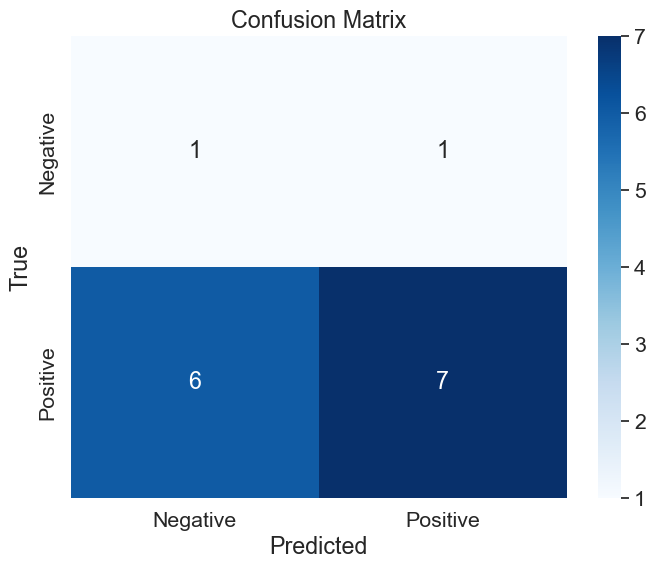

DOTBRL 

['BTCBRL', 'MyGamble: 344215.19 ', 'GambleProft: 1.003', 'SoldStatus: 1', 'TruePrice: 344444.0  ', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2497.98   ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 2463.0    ', 'CorrectModel: 1']
['XRPBRL', 'MyGamble: 3.184     ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 3.125     ', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.711     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 3.74      ', 'CorrectModel: 1']
['DOTBRL', 'MyGamble: 54.06     ', 'GambleProft: 1.008', 'SoldStatus: 0', 'TruePrice: 52.91     ', 'CorrectModel: 0']
['BTTBRL', 'MyGamble: 0.014     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 0.015     ', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 0.001     ', 'CorrectModel: 1']
Loss: 13760473.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 349680.375 / Pred2: 350179.312 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyA

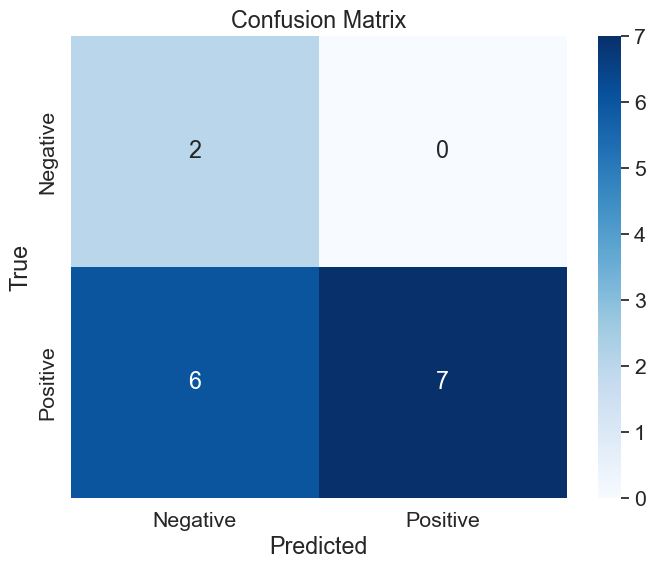

['BTCBRL', 'MyGamble: 349330.695', 'GambleProft: 1.018', 'SoldStatus: 0', 'TruePrice: 344444.0  ', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2480.223  ', 'GambleProft: 1.013', 'SoldStatus: 0', 'TruePrice: 2463.0    ', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 99.352    ', 'GambleProft: 1.002', 'SoldStatus: 1', 'TruePrice: 100.73    ', 'CorrectModel: 1']
['LTCBRL', 'MyGamble: 448.83    ', 'GambleProft: 1.01 ', 'SoldStatus: 1', 'TruePrice: 456.6     ', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 0.015     ', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 0.001     ', 'CorrectModel: 1']
Loss: 13105098.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 344967.875 / Pred2: 344768.281 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 344622.907 / GambleProft: 1.005 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.00015063

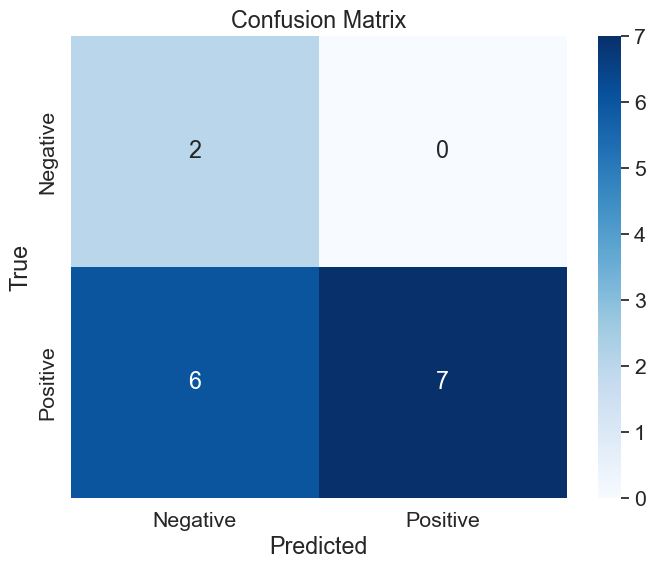

['BTCBRL', 'MyGamble: 344622.907', 'GambleProft: 1.005', 'SoldStatus: 1', 'TruePrice: 344444.0  ', 'CorrectModel: 1']
['USDTBRL', 'MyGamble: 5.045     ', 'GambleProft: 1.002', 'SoldStatus: 1', 'TruePrice: 5.042     ', 'CorrectModel: 1']
['ETHBRL', 'MyGamble: 19604.742 ', 'GambleProft: 1.002', 'SoldStatus: 1', 'TruePrice: 19691.93  ', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2478.255  ', 'GambleProft: 1.012', 'SoldStatus: 0', 'TruePrice: 2463.0    ', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.774     ', 'GambleProft: 1.002', 'SoldStatus: 1', 'TruePrice: 0.781     ', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 0.015     ', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 0.001     ', 'CorrectModel: 1']


In [39]:
for i in range(3):
    pred_eval(model_4, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 8481336.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 343056.438 / Pred2: 345983.125 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 2.699813740036916e-05
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.035      / Pred2: 5.047      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 115427.4375
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19874.002  / Pred2: 20094.643  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 19874.002  / GambleProft: 1.016 / TrueProft: 1.007 || CorrectModel: 1
Loss: 6062.47119140625
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2523.677   / Pred2: 2576.113   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus: 

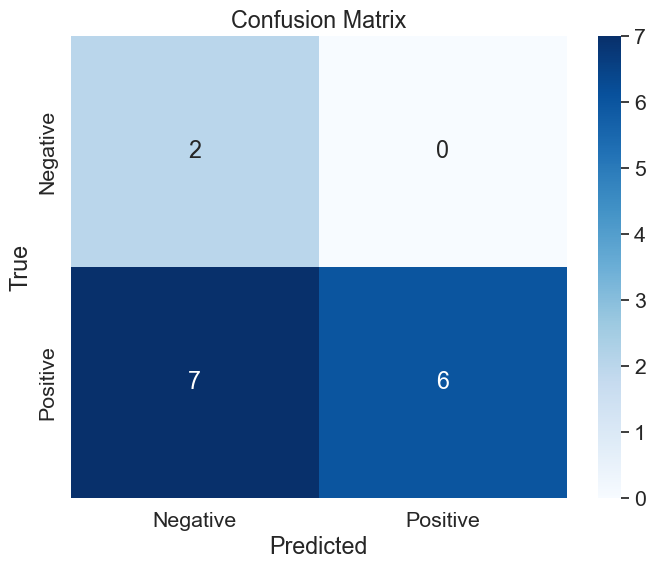

['ETHBRL', 'MyGamble: 19874.002 ', 'GambleProft: 1.016', 'SoldStatus: 0', 'TruePrice: 19691.93  ', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2497.98   ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 2463.0    ', 'CorrectModel: 1']
Loss: 57475820.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 339674.531 / Pred2: 340258.719 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.002865438349545002
2   USDTBRL  - LastPrice: 5.036      / Pred1: 4.981      / Pred2: 5.0        / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 48194.3203125
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19382.057  / Pred2: 19630.836  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamb

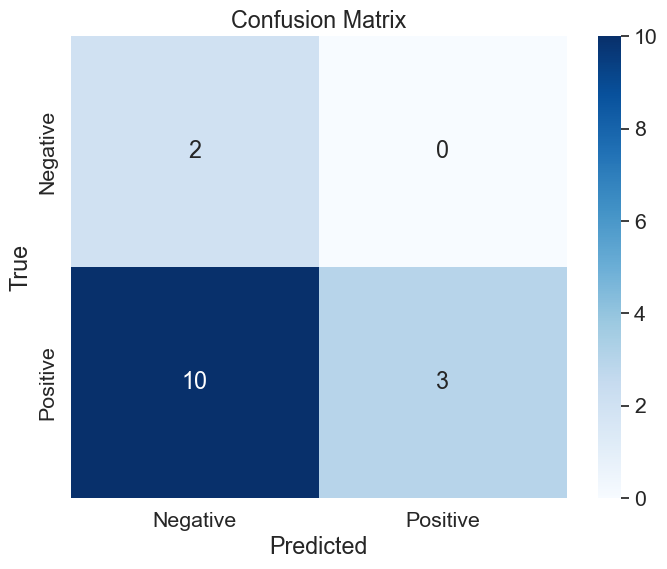

['ADABRL', 'MyGamble: 3.711     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 3.74      ', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.776     ', 'GambleProft: 1.005', 'SoldStatus: 1', 'TruePrice: 0.781     ', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 0.015     ', 'CorrectModel: 1']
Loss: 82974880.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 354126.031 / Pred2: 358358.469 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 349911.0   / GambleProft: 1.02  / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0003128105599898845
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.019      / Pred2: 5.035      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 14844.6142578125
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19531.633  / Pre

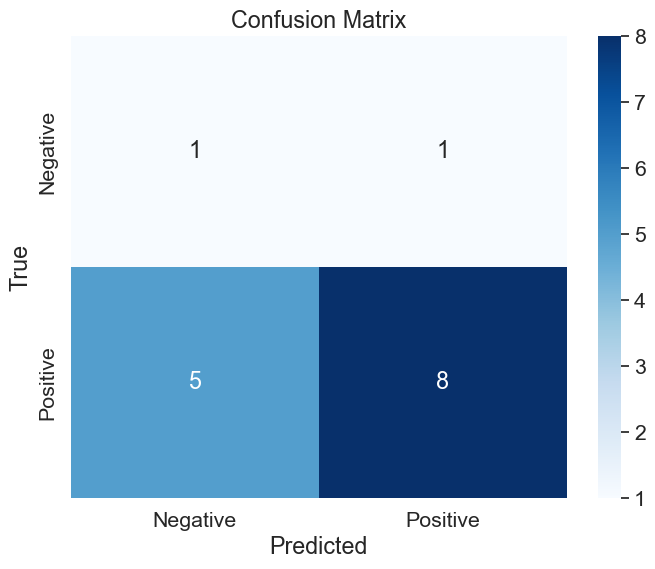

DOTBRL 

['BTCBRL', 'MyGamble: 349911.0  ', 'GambleProft: 1.02 ', 'SoldStatus: 0', 'TruePrice: 344444.0  ', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2489.353  ', 'GambleProft: 1.016', 'SoldStatus: 0', 'TruePrice: 2463.0    ', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.838     ', 'GambleProft: 1.012', 'SoldStatus: 1', 'TruePrice: 0.902     ', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.711     ', 'GambleProft: 1.02 ', 'SoldStatus: 1', 'TruePrice: 3.74      ', 'CorrectModel: 1']
['DOTBRL', 'MyGamble: 54.92     ', 'GambleProft: 1.024', 'SoldStatus: 0', 'TruePrice: 52.91     ', 'CorrectModel: 0']
['CHZBRL', 'MyGamble: 0.782     ', 'GambleProft: 1.012', 'SoldStatus: 1', 'TruePrice: 0.781     ', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'GambleProft: 1.019', 'SoldStatus: 1', 'TruePrice: 0.015     ', 'CorrectModel: 1']


In [40]:
for i in range(3):
    pred_eval(model_5, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 81636688.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 334814.812 / Pred2: 341461.469 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0008634378318674862
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.001      / Pred2: 5.036      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 19089.806640625
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19506.406  / Pred2: 19711.318  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 12677.2783203125
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2450.346   / Pred2: 2509.272   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActSta

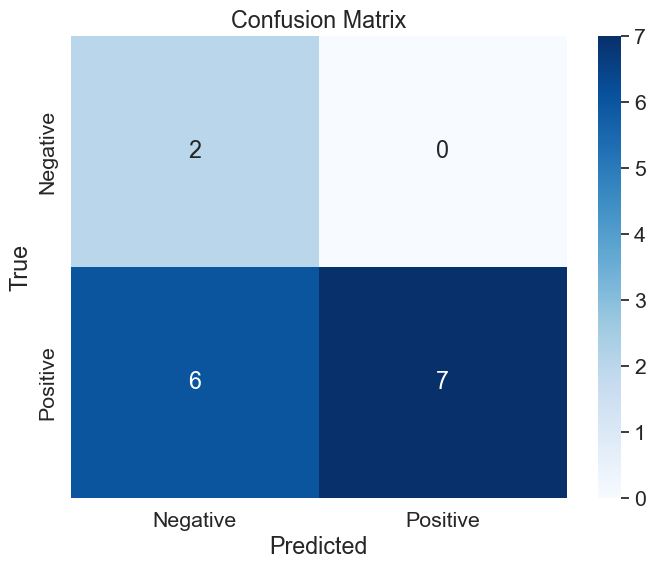

['LINKBRL', 'MyGamble: 99.818    ', 'TruePrice: 100.73    ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.832     ', 'TruePrice: 0.902     ', 'GambleProft: 1.004', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.788     ', 'TruePrice: 0.781     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 4322221.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 346720.438 / Pred2: 348000.281 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 346373.717 / GambleProft: 1.01  / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0024198172613978386
2   US

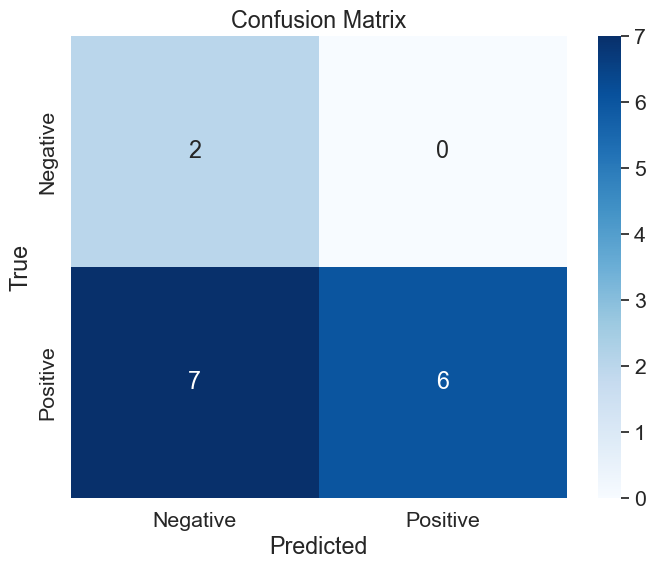

['BTCBRL', 'MyGamble: 346373.717', 'TruePrice: 344444.0  ', 'GambleProft: 1.01 ', 'TrueProft: 1.004', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2458.177  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.004', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 102.709   ', 'TruePrice: 100.73    ', 'GambleProft: 1.035', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.648     ', 'TruePrice: 3.74      ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
Loss: 42354400.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 337268.656 / Pred2: 344097.031 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.00039965371252037585
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.016      / Pred2: 5.034      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 

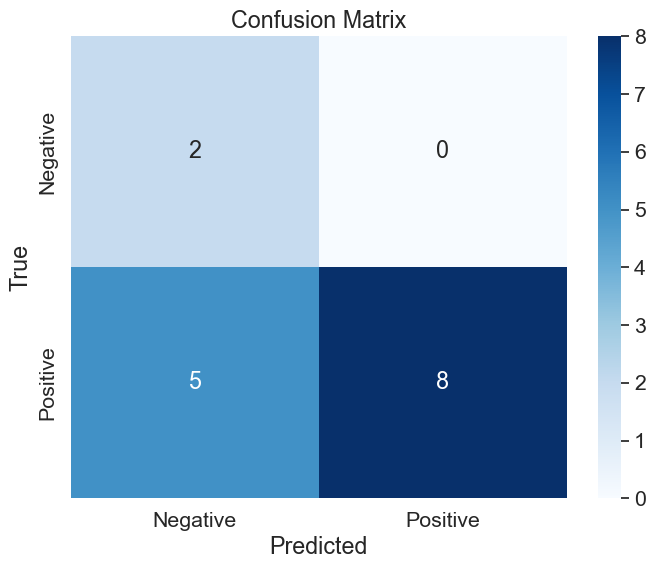

['ETHBRL', 'MyGamble: 19613.121 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2491.786  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.017', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL', 'MyGamble: 4.986     ', 'TruePrice: 4.977     ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL', 'MyGamble: 3.132     ', 'TruePrice: 3.125     ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 100.093   ', 'TruePrice: 100.73    ', 'GambleProft: 1.009', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.758     ', 'TruePrice: 3.74      ', 'GambleProft: 1.033', 'TrueProft: 1.028', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     

In [45]:
for i in range(3):
    pred_eval(model_6, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 10803847.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 343178.25  / Pred2: 345388.25  / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 0.0009148840908892453
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.009      / Pred2: 5.018      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 62137.078125
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19433.633  / Pred2: 19410.09   / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 9295.2783203125
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2488.965   / Pred2: 2534.148   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStatus:

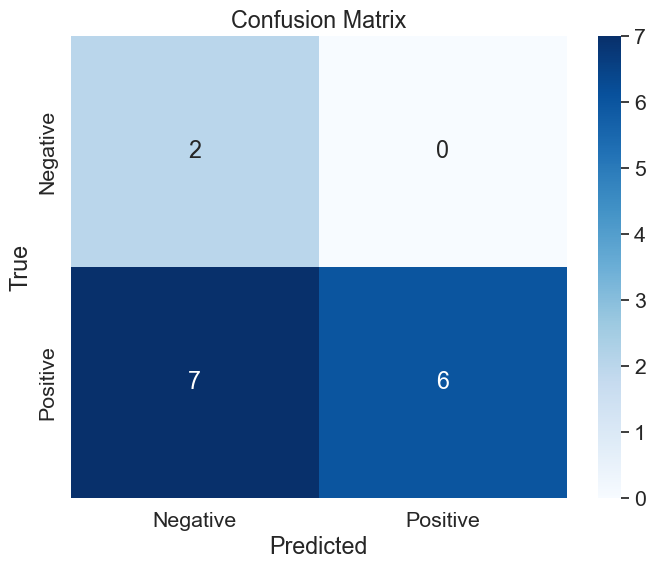

['BNBBRL', 'MyGamble: 2488.965  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.016', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.711     ', 'TruePrice: 3.74      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.788     ', 'TruePrice: 0.781     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.035', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 10654116.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 343522.156 / Pred2: 345337.875 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343178.634 / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 0.00726962648332119
2   USDTBRL  - LastPrice: 5.036      / Pred1: 4.954      / Pred2: 4.963      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / My

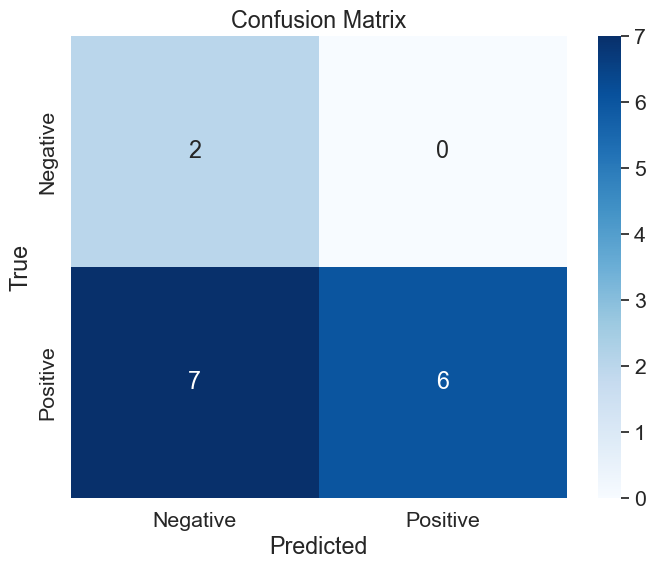

['ETHBRL', 'MyGamble: 19787.201 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.012', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2497.98   ', 'TruePrice: 2463.0    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
Loss: 5879421.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 342917.406 / Pred2: 346790.469 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 7.697213732171804e-06
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.042      / Pred2: 5.049      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.037      / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 39440.8828125
3   ET

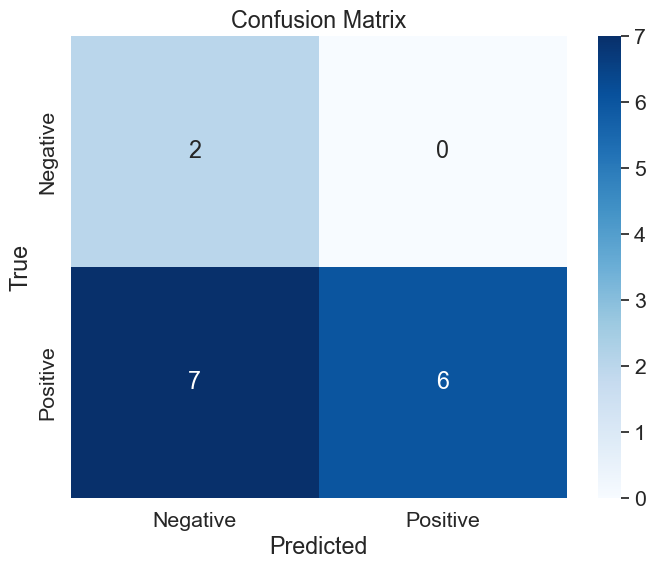

['ETHBRL', 'MyGamble: 19829.494 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.014', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2497.98   ', 'TruePrice: 2463.0    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 101.174   ', 'TruePrice: 100.73    ', 'GambleProft: 1.02 ', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.788     ', 'TruePrice: 0.781     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']


In [46]:
for i in range(3):
    pred_eval(model_7, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 61657912.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 336878.844 / Pred2: 341731.75  / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.000327155867125839
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.02       / Pred2: 5.032      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 22644.830078125
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19504.574  / Pred2: 19549.066  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 11187.4052734375
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2518.892   / Pred2: 2529.252   / TruePrice1: 2463.0     / TruePrice2: 2668.0     || ActStat

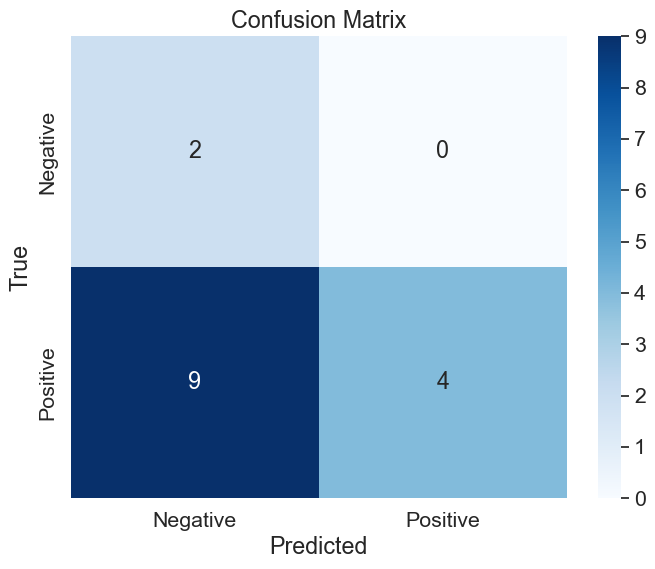

['BNBBRL', 'MyGamble: 2516.373  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.028', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL', 'MyGamble: 3.196     ', 'TruePrice: 3.125     ', 'GambleProft: 1.024', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 7655972.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 344774.938 / Pred2: 345961.938 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 344430.163 / GambleProft: 1.004 / TrueProft: 1.004 || CorrectModel: 1
Loss: 0.0008943240973167121
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.001      / Pred2: 5.036      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / M

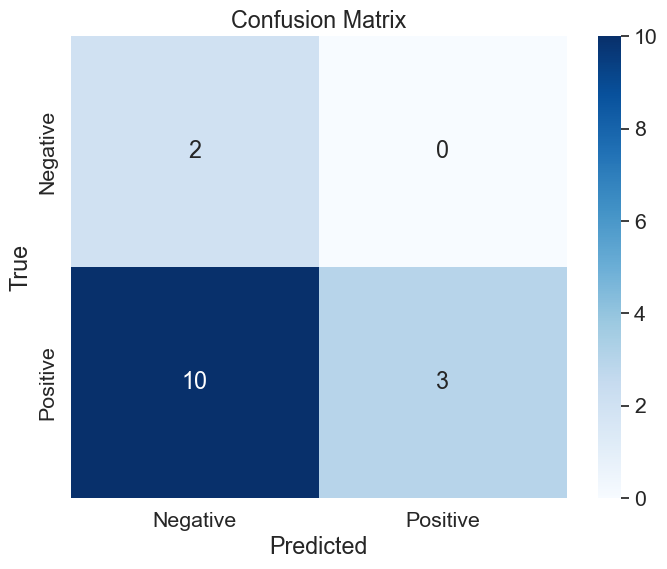

['BTCBRL', 'MyGamble: 344430.163', 'TruePrice: 344444.0  ', 'GambleProft: 1.004', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
Loss: 7837955.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 341001.688 / Pred2: 351817.062 / TruePrice1: 344444.0   / TruePrice2: 349861.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0009531603427603841
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.009      / Pred2: 5.016      / TruePrice1: 5.042      / TruePrice2: 5.045      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 25537.927734375
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19477.244  / Pred2: 19720.605  / TruePrice1: 19691.93   / TruePrice2: 19650.0    || ActStatus: 0

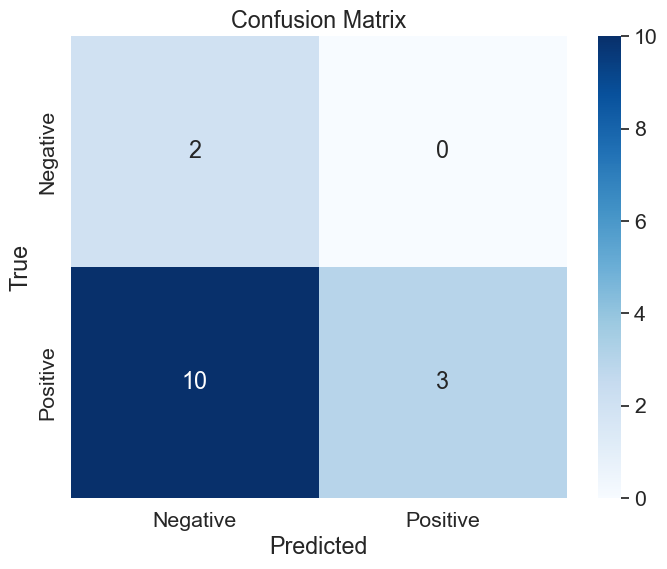

['BNBBRL', 'MyGamble: 2497.98   ', 'TruePrice: 2463.0    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.013', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']


In [47]:
for i in range(3):
    pred_eval(model_8, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
